#Computer Vision (CV) Challenge: Use a pre-trained ResNet 50 and train on the Flowers dataset.

102 category dataset consists of 102 flower categories. The flowers chosen to be flower commonly occuring in the United Kingdom. Each class consists of between 40 and 258 images. 

The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import os
import glob
import random
import tqdm
import torchvision.transforms as transforms
import scipy.io as scp
import pandas as pd
import numpy as np
import skimage.io as skio
 

# Unzipping files

In [3]:
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "./102flower.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Extracting all the files now...
Done!


In [4]:
#image path
input_path = "./102flower/"
#label path
label_path = './imagelabels.mat'
label_arr = scp.loadmat(label_path)['labels']
# subtrating by 1 to make align to label 0
label_arr -= 1
labels_list = list(label_arr[0, :])
image_path_list = sorted(glob.glob('./102flower/*.jpg'))


Creating dataframe

In [5]:
# data frame of image path and image label
metadata = pd.DataFrame(
    {'image_path': image_path_list,
     'image_label': labels_list}
)
metadata

,image_path,image_label
0,/content/102flower/image_00001.jpg,76
1,/content/102flower/image_00002.jpg,76
2,/content/102flower/image_00003.jpg,76
3,/content/102flower/image_00004.jpg,76
4,/content/102flower/image_00005.jpg,76
...,...,...
8184,/content/102flower/image_08185.jpg,61
8185,/content/102flower/image_08186.jpg,61
8186,/content/102flower/image_08187.jpg,61
8187,/content/102flower/image_08188.jpg,61


Ploting images

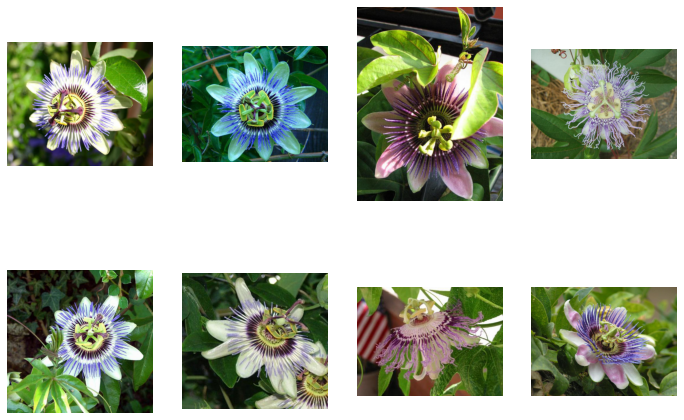

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,8))
for i in range(2):
    for j in range(4):
      ax[i,j].imshow(plt.imread( metadata['image_path'][i*4+j] )) # first converting to image from path and visualizing the image
      ax[i,j].axis('off')

#Creating model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 228),
               nn.ReLU(inplace=True),
               nn.Linear(228, 102)).to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

#Creating dataset and spliting dataset

In [ ]:
class MyFlowerDataset(Dataset):
  def __init__(self, metadata, transform=None):
    self.metadata = metadata
    self.transform = transform

  def __len__(self):
    return len(self.metadata)

  def __getitem__(self, idx):
    image_path = self.metadata.iloc[idx, 0]
    image = skio.imread(image_path)
    label = torch.tensor(int(metadata.iloc[idx, 1]))
    label = F.one_hot(label, num_classes=102)
    label = label.float()
    if self.transform:
      image = self.transform(image)

    return (image, label)

flower_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_W, IMAGE_H)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = MyFlowerDataset(metadata, transform = flower_transform)

# Splitting dataset into train and test
train_set, test_set = torch.utils.data.random_split(dataset, [6500, 1689])

# defining the dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)


#Training the model

In [ ]:
NUM_OUT_CH = [8, 16]
IMAGE_W = 224
IMAGE_H = 224
BATCH_SIZE = 64
NUM_EPOCHS = 10

# Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [ ]:
for epoch in range(NUM_EPOCHS):
  running_loss = 0
  for index, (x,y) in enumerate(train_loader):
    # send the data to the device
    x = x.to(device)
    y = y.to(device)
    # forward
    y_hat = model(x)
    loss = criterion(y_hat, y)
    running_loss += loss
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch}: loss: {running_loss}")

Epoch 0: loss: 84.18637084960938
Epoch 1: loss: 53.78548812866211
Epoch 2: loss: 38.895809173583984
Epoch 3: loss: 31.44063949584961
Epoch 4: loss: 25.47881317138672
Epoch 5: loss: 21.124279022216797
Epoch 6: loss: 17.419282913208008
Epoch 7: loss: 14.030335426330566
Epoch 8: loss: 11.413313865661621
Epoch 9: loss: 10.436784744262695


#Checking the accuracy of model 

In [ ]:
def check_accuracy(loader, model):
  num_corrects = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      # sending the data to the device
      x = x.to(device)
      y = y.to(device)

      # forward
      y_hat = model(x)

      # calculate the accuracy
      _, labels = y.max(1)
      _, predictions = y_hat.max(1)
      num_corrects += (predictions == labels).sum()
      num_samples += predictions.size(0)

  print(f"Accuracy: {num_corrects}/{num_samples}: {num_corrects/num_samples*100:.2f}")



check_accuracy(test_loader, model)


Accuracy: 1547/1689: 91.59


#Saving model

In [ ]:
!mkdir models
!mkdir models/pytorch
torch.save(model.state_dict(), 'models/pytorch/weights.h5')

#Loading Model

In [ ]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 228),
               nn.ReLU(inplace=True),
               nn.Linear(228, 102)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 